# Fake News detection

In [1]:
import os
import re
import ssl
import pickle
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix, f1_score

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/richardph911/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/richardph911/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Keep only letters
    words = [lemmatizer.lemmatize(word) for word in text.split() 
             if word not in stop_words and len(word) > 2]
    return " ".join(words)

### Drop columns "subject" and "subject". Add column "label"

In [3]:
def load_liar_data():
    cols = ["id", "label", "statement", "subject", "speaker", "job", "state", "party", 
            "barely_true", "false", "half_true", "mostly_true", "pants_fire", "context"]
    train_df = pd.read_csv("data/train.tsv", sep="\t", names=cols)
    val_df = pd.read_csv("data/valid.tsv", sep="\t", names=cols)
    test_df = pd.read_csv("data/test.tsv", sep="\t", names=cols)
    return train_df, val_df, test_df

train_df, val_df, test_df = load_liar_data()

# === Convert labels to binary ===
label_map = {
    "pants-fire": 0,
    "false": 0,
    "barely-true": 0,
    "half-true": 1,
    "mostly-true": 1,
    "true": 1
}

for name, df in zip(["train", "val", "test"], [train_df, val_df, test_df]):
    df.dropna(subset=["label", "statement"], inplace=True)
    df = df[df["label"].isin(label_map)].copy()
    df["label"] = df["label"].map(label_map)
    df["input"] = (
    df["statement"].astype(str) + " " +
    df["subject"].astype(str) + " " +
    df["context"].astype(str) + " " +
    df["party"].astype(str) + " " +
    df["speaker"].astype(str)

    ).apply(preprocess_text)
    
    # Assign it back to the correct variable name
    if name == "train":
        train_df = df
    elif name == "val":
        val_df = df
    else:
        test_df = df


# # === Preprocess the statement text ===
# train_df["cleaned"] = train_df["statement"].apply(preprocess_text)
# val_df["cleaned"] = val_df["statement"].apply(preprocess_text)
# test_df["cleaned"] = test_df["statement"].apply(preprocess_text)


In [4]:
df_all = pd.concat([train_df, val_df]).reset_index(drop=True)

X_train_text = df_all["input"]
y_train = df_all["label"]

X_test_text = test_df["input"]
y_test = test_df["label"]

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2,
    sublinear_tf=True,
    stop_words='english'
)


X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# from imblearn.over_sampling import SMOTE


# Model training


==== Logistic Regression ====
Test Accuracy: 0.6346, F1 Score: 0.5894
CV Accuracy: 0.6184 ± 0.0053
              precision    recall  f1-score   support

           0       0.71      0.28      0.40       553
           1       0.62      0.91      0.74       714

    accuracy                           0.63      1267
   macro avg       0.66      0.59      0.57      1267
weighted avg       0.66      0.63      0.59      1267


==== Naive Bayes ====
Test Accuracy: 0.6598, F1 Score: 0.6557
CV Accuracy: 0.6290 ± 0.0112
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       553
           1       0.68      0.75      0.71       714

    accuracy                           0.66      1267
   macro avg       0.65      0.65      0.65      1267
weighted avg       0.66      0.66      0.66      1267



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner


==== XGBoost ====
Test Accuracy: 0.6219, F1 Score: 0.6129
CV Accuracy: 0.6153 ± 0.0073
              precision    recall  f1-score   support

           0       0.59      0.45      0.51       553
           1       0.64      0.75      0.69       714

    accuracy                           0.62      1267
   macro avg       0.61      0.60      0.60      1267
weighted avg       0.62      0.62      0.61      1267


==== Gradient Boosting ====
Test Accuracy: 0.6125, F1 Score: 0.5868
CV Accuracy: 0.6218 ± 0.0089
              precision    recall  f1-score   support

           0       0.60      0.34      0.43       553
           1       0.62      0.82      0.71       714

    accuracy                           0.61      1267
   macro avg       0.61      0.58      0.57      1267
weighted avg       0.61      0.61      0.59      1267


==== KNN ====
Test Accuracy: 0.5801, F1 Score: 0.5774
CV Accuracy: 0.5841 ± 0.0069
              precision    recall  f1-score   support

           0       0.

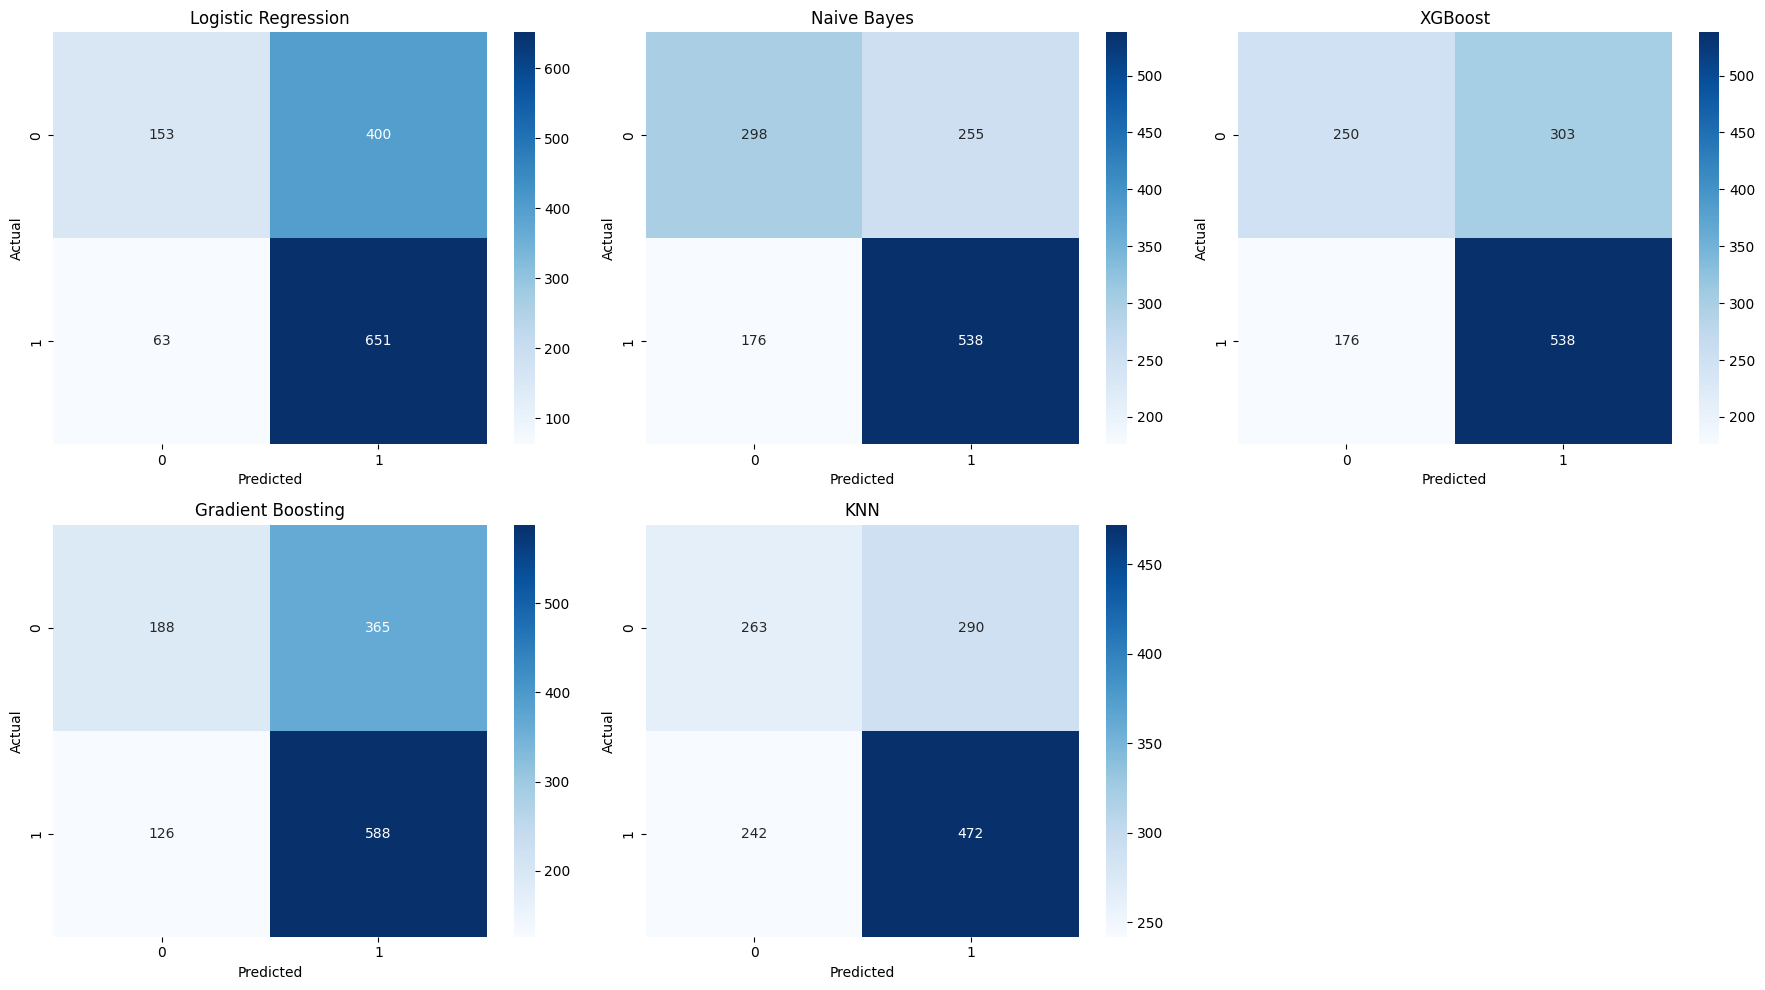

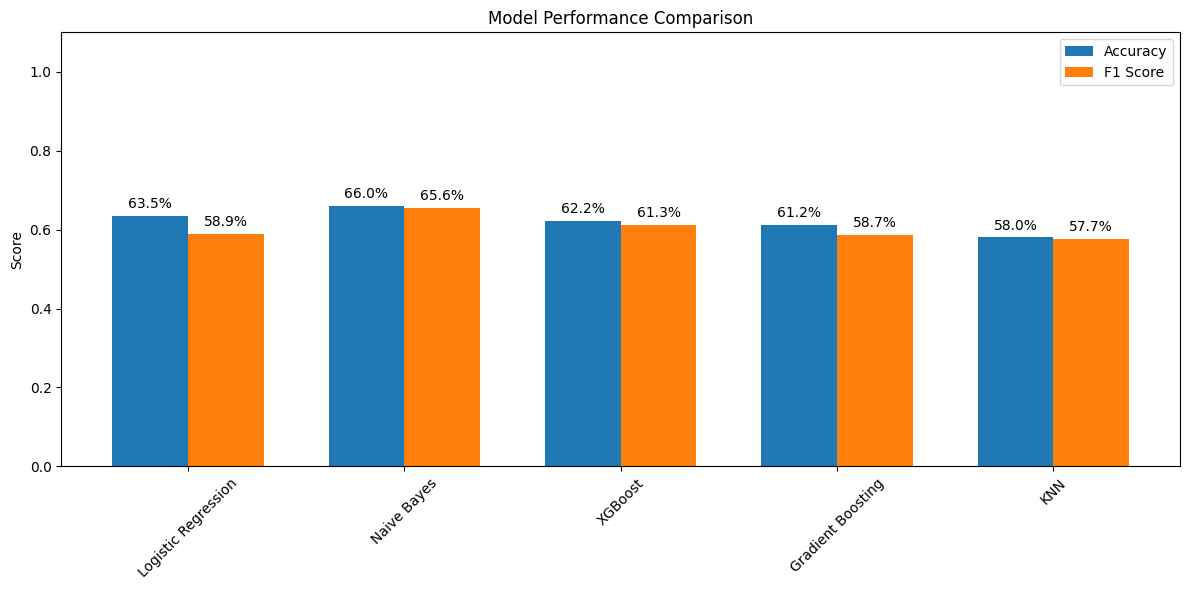

In [5]:
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import ComplementNB

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=0.1,solver='liblinear'),
    'Naive Bayes': ComplementNB(alpha=2),
    # "SVC": SVC(probability=True, random_state=42), 
    # "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5), 
    "XGBoost" : XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
    # "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.8),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


results = {}
trained_models = {}

# --- Training and evaluation ---
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    results[name] = {
        "accuracy": acc,
        "f1": f1,
        "confusion_matrix": cm,
        "cv_mean": cv_scores.mean(),
        "cv_std": cv_scores.std(),
        "y_pred": y_pred
    }

    trained_models[name] = model

    print(f"\n==== {name} ====")
    print(f"Test Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Automatically get correct labels
    label_names = [str(l) for l in sorted(unique_labels(y_test, y_pred))]
    print(classification_report(y_test, y_pred, target_names=label_names))

# --- Confusion Matrices ---
fig_cols = 3
fig_rows = (len(results) + fig_cols - 1) // fig_cols
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(6 * fig_cols, 5 * fig_rows))
axes = axes.flatten()

for i, (name, res) in enumerate(results.items()):
    sns.heatmap(res["confusion_matrix"], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

# Remove unused plots
for j in range(len(results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# --- Bar Chart of Accuracy and F1 ---
model_names = list(results.keys())
accuracies = [results[name]["accuracy"] for name in model_names]
f1_scores = [results[name]["f1"] for name in model_names]

plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.35

bars1 = plt.bar(x - width / 2, accuracies, width, label='Accuracy')
bars2 = plt.bar(x + width / 2, f1_scores, width, label='F1 Score')

plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.xticks(x, model_names, rotation=45)
plt.ylim(0, 1.1)

# Add % labels above each bar
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{bar.get_height()*100:.1f}%", ha="center")

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{bar.get_height()*100:.1f}%", ha="center")

plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# plt.figure(figsize=(10, 8))
# trained_models = {}              

# for name, model in models.items():
#     if hasattr(model, "predict_proba"):
#         y_proba = model.predict_proba(X_test)[:, 1]
#     else:
#         y_proba = model.decision_function(X_test)
#     fpr, tpr, _ = roc_curve(y_test, y_proba)
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
#     trained_models[name] = model

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve Comparison')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores[name] = scores
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}, Std = {scores.std():.4f}")

Logistic Regression: Mean Accuracy = 0.6143, Std = 0.0036
Naive Bayes: Mean Accuracy = 0.6271, Std = 0.0072


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:44:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:44:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:44:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost: Mean Accuracy = 0.6099, Std = 0.0050
Gradient Boosting: Mean Accuracy = 0.6174, Std = 0.0034
KNN: Mean Accuracy = 0.5843, Std = 0.0029


In [8]:
# Calculate weighted scores for each model
def model_score(res, f1_weight=0.6, acc_weight=0.4):
    return f1_weight * res['f1'] + acc_weight * res['accuracy']

scores = {name: model_score(res) for name, res in results.items()}
best_model = max(scores, key=scores.get)
best_score = scores[best_model]
best_model_name = model_names[np.argmax(accuracies)]
best_model = trained_models[best_model_name]

print(f"Best model: {best_model} with score: {best_score:.4f}")

Best model: ComplementNB(alpha=2) with score: 0.6573


### Save model and vectorizer for deployment

In [9]:
os.makedirs('models', exist_ok=True) # make directory if it doesn't exist
with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

### Deploy

In [10]:
def detectNews(text):

    with open("models/best_model.pkl", "rb") as f:
        model = pickle.load(f)
    print("best model saved as ", type(model).__name__)

    with open('models/tfidf_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)

    """Classify news text as Real or Fake."""
    processed_text = preprocess_text(text)
    text_vector = vectorizer.transform([processed_text])
    prediction = model.predict(text_vector)
    probability = model.predict_proba(text_vector)

    label = "Real News" if prediction[0] == 1 else "Fake News"
    confidence = probability[0][prediction[0]]

    return label, confidence

In [11]:
sample_text = "hello world"
result, confidence = detectNews(sample_text)
print(f"Result: {result} with confidence: {confidence:.2f}")

best model saved as  ComplementNB
Result: Real News with confidence: 0.61


# References:
1. https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data
